In [1]:
import duckdb
import pandas as pd
import torch
import numpy as np
import pickle
from collections import defaultdict
import os
import json
import scipy.sparse as sp
from factorize import factorize
from tqdm import tqdm
from tabulate import tabulate
import random
from atproto import Client
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create/connect to DuckDB database
con = duckdb.connect('../random_tests/scan_results.duckdb')

# Load the pre-computed mappings
def load_mappings_pickle():
    with open('id_mappings.pkl', 'rb') as f:
        mappings = pickle.load(f)
        post_to_idx = mappings['post_to_idx']
        post_likes = defaultdict(list, mappings['post_likes'])
    return post_to_idx, post_likes

print("Loading mappings...")
post_to_idx, post_likes = load_mappings_pickle()

train_producer_df = con.execute("""
WITH producers AS (
    SELECT 
        json_extract_string(record, '$.subject') as producer_did
    FROM records 
    WHERE collection = 'app.bsky.graph.follow'
    AND createdAt < '2023-06-15'  -- before training cutoff date
    GROUP BY json_extract_string(record, '$.subject')
    HAVING COUNT(*) >= 30
)
SELECT producer_did
FROM producers
""").fetchdf()

train_edges_df = con.execute("""
SELECT 
    repo as consumer_did,
    json_extract_string(record, '$.subject') as producer_did
FROM records
WHERE 
    collection = 'app.bsky.graph.follow'
    AND json_extract_string(record, '$.subject') IN (SELECT producer_did FROM train_producer_df)
""").fetchdf()

test_likes_df = con.execute("""
    SELECT 
        repo as consumer_did,  -- who did the liking
        json_extract_string(record, '$.subject.uri') as post_uri,  -- which post was liked
        createdAt -- when was it liked
    FROM records 
    WHERE collection = 'app.bsky.feed.like'
    AND createdAt >= '2023-06-15' AND createdAt < '2023-06-16'
    AND repo IN (SELECT DISTINCT consumer_did FROM train_edges_df)
""").fetchdf()

def load_mapping(mapping_file):
    """
    Load a mapping from a JSON file. If the file doesn't exist, return an empty dict.
    """
    if os.path.exists(mapping_file):
        with open(mapping_file, "r") as f:
            mapping = json.load(f)
    else:
        mapping = {}
    return mapping

consumer_mapping_file = 'consumer_mapping.json'
producer_mapping_file = 'producer_mapping.json'

consumer_to_idx = load_mapping(consumer_mapping_file)
producer_to_idx = load_mapping(producer_mapping_file)

# Copy to avoid modifying the original DataFrame
test_likes_mapped_df = test_likes_df.copy()

# Map the DIDs to indices
test_likes_mapped_df['consumer_idx'] = test_likes_mapped_df['consumer_did'].map(consumer_to_idx)
test_likes_mapped_df['post_idx'] = test_likes_mapped_df['post_uri'].map(post_to_idx)

# Drop rows where mapping is missing
test_likes_mapped_df.dropna(subset=['consumer_idx', 'post_idx'], inplace=True)

# Convert the mapped values to integers
test_likes_mapped_df['consumer_idx'] = test_likes_mapped_df['consumer_idx'].astype(int)
test_likes_mapped_df['post_idx'] = test_likes_mapped_df['post_idx'].astype(int)

# Drop the original ID columns
test_likes_mapped_df.drop(['consumer_did', 'post_uri'], axis=1, inplace=True)

# Create sparse matrix in COO format; each edge has weight 1
rows = [consumer_to_idx[consumer] for consumer in train_edges_df['consumer_did']]
cols = [producer_to_idx[producer] for producer in train_edges_df['producer_did']]
data = np.ones(len(rows))

# Build the sparse matrix (then convert to CSR format for efficient multiplication)
matrix = sp.coo_matrix(
    (data, (rows, cols)),
    shape=(len(consumer_to_idx), len(producer_to_idx))
)

print("\nStats:")
print(f"Number of test likes: {len(test_likes_df)}")
print(f"Number of unique consumers in test: {test_likes_df['consumer_did'].nunique()}")
print(f"Number of unique posts in test: {test_likes_df['post_uri'].nunique()}")
print("Matrix shape:", matrix.shape)

Loading mappings...

Stats:
Number of test likes: 312166
Number of unique consumers in test: 15833
Number of unique posts in test: 95110
Matrix shape: (132728, 37192)


In [2]:
# import pandas as pd
# import time
# from tqdm import tqdm

# client = Client()
# client.login('c-weed.bsky.social', 'bfv3-pzy2-r2lh-aoyp')

# # Create a function to get profile info with error handling
# def get_profile_safe(did):
#     """Fetch profile information from Bluesky API with error handling"""
#     try:
#         response = client.get_profile(did)
#         return {
#             'did': did,
#             'handle': response.handle,
#             'display_name': response.display_name,
#             'description': response.description,
#             'followers': response.followers_count,
#             'following': response.follows_count,
#             'posts': response.posts_count,
#             'joined': response.created_at
#         }
#     except Exception as e:
#         return {
#             'did': did,
#             'handle': None,
#             'display_name': None,
#             'description': None,
#             'followers': None,
#             'following': None,
#             'posts': None,
#             'joined': None,
#             'error': str(e)
#         }

# # Get all producer profiles
# producer_profiles = []
# for did, idx in tqdm(producer_to_idx.items(), desc="Fetching profiles"):
#     profile = get_profile_safe(did)
#     profile['producer_idx'] = idx  # Add the index
#     producer_profiles.append(profile)
#     time.sleep(0.1)  # Rate limiting - 10 requests per second

# # Convert to DataFrame
# producer_df = pd.DataFrame(producer_profiles)

# # Reorder columns for better readability
# columns_order = [
#     'producer_idx', 'did', 'handle', 'display_name', 'description',
#     'followers', 'following', 'posts', 'joined', 'error'
# ]
# producer_df = producer_df[columns_order]

# # Save to CSV
# producer_df.to_parquet('producer_profiles.parquet')
# print("\nProducer profiles saved to producer_profiles.csv")

# # Display some basic stats
# print("\nProfile fetch summary:")
# print(f"Total producers: {len(producer_df)}")
# print(f"Successful fetches: {len(producer_df[producer_df['error'].isna()])}")
# print(f"Failed fetches: {len(producer_df[producer_df['error'].notna()])}")

In [3]:
loaded_producer_df = pd.read_parquet('producer_profiles.parquet')
loaded_producer_df

,producer_idx,did,handle,display_name,description,followers,following,posts,joined,error
0,0,did:plc:nywb5oene54cllowkfwouxzz,chadloder.bsky.social,Chad Loder,"Community activist, cybersecurity expert, citi...",54792.0,1377.0,10515.0,2023-04-30T18:10:33.161Z,None
1,1,did:plc:mnfnfpykrohxbck6av3f7los,blkmatters3000.bsky.social,Michael E Hopson,Organizer. Abolitionist \nHe/him,134.0,23.0,5.0,2023-05-01T22:40:48.536Z,None
2,2,did:plc:kfdf3ncmu3ekd3yrorivypai,lolennui.bsky.social,Amy Ash,onion lady \n\nhttps://lolennui.com,52062.0,819.0,3329.0,2023-04-27T15:52:02.340Z,None
3,3,did:plc:rwbe4e7d7o3fwwcqkoyjvp4v,rui.bsky.social,Rui,None,5196.0,43075.0,29.0,2023-04-11T18:05:18.291Z,None
4,4,did:plc:krt7ulietkhjowpctmv2iphb,paulio.bsky.social,Paulio 🥚,None,1730.0,956.0,1138.0,2023-05-02T02:45:41.097Z,None
...,...,...,...,...,...,...,...,...,...,...
37187,37187,did:plc:3u3pydxppxck3jntgs2wcwhh,arielsonline.bsky.social,ariel,that girl from the other blue app,103.0,37.0,6.0,2023-05-06T15:27:23.628Z,None
37188,37188,did:plc:3zlq22qdm35eswu5nkbkwphc,handle.invalid,None,None,75.0,0.0,0.0,2023-05-06T22:13:05.448Z,None
37189,37189,did:plc:uh2xhvsj4kcojgenqs5iweqx,haiverart.bsky.social,Haiver,Artistic Director at Alba.art ⏀ Generative Art...,376.0,272.0,103.0,2023-05-17T17:51:50.801Z,None
37190,37190,did:plc:bucblzi2mx576tqo5tuxwynq,thisisradinsky.bsky.social,RADINSKY 🪬🏳️‍⚧️,Anatoliy Osman-Douša 🏳️‍⚧️\nIllustrator &​ Aut...,9805.0,941.0,1792.0,2023-05-14T11:02:35.774Z,None


In [4]:
torch.manual_seed(42)  # IMPORTANT: temporary solution for deterministic results. Need this so that consumer_embeddings stays the same across runs.
producer_communities, producer_community_affinities, consumer_embeddings, producer_embeddings, kmeans_cluster_centers = factorize(
    matrix, 
    n_components=128,
    n_clusters=100,
    device=device
)

# Save producer embeddings and communities
# torch.save(producer_embeddings, 'producer_embeddings.pt')
# np.save('producer_communities.npy', producer_communities)

In [5]:
# import torch
# from torch_geometric.nn.models import LightGCN
# import torch_geometric.transforms as T
# from torch_geometric.data import Data
# from torch.nn import functional as F

# consumer_embeddings = torch.tensor(consumer_embeddings, device=device)
# producer_embeddings = torch.tensor(producer_embeddings, device=device)

# combined_embeddings = torch.cat((consumer_embeddings, producer_embeddings), dim=0)

# # Convert the sparse matrix to edge_index format for PyG
# def sparse_to_edge_index(sparse_matrix):
#     """Convert scipy sparse matrix to PyG edge_index format"""
#     coo = sparse_matrix.tocoo()
#     indices = np.vstack((coo.row, coo.col))
#     return torch.LongTensor(indices).to(device)

# # Create edge index from matrix
# edge_index = sparse_to_edge_index(matrix)

# # Initialize LightGCN model
# num_nodes = matrix.shape[0] + matrix.shape[1]  # Total number of nodes (consumers + producers)

# # Convert our data into PyG Data object
# data = Data(
#     edge_index=edge_index,
#     num_nodes=num_nodes,
#     num_users=matrix.shape[0]  # number of consumers
# )

# # Initialize LightGCN model
# model = LightGCN(
#     num_nodes=num_nodes,
#     embedding_dim=64,
#     num_layers=2
# ).to(device)

# # Initialize LightGCN with SVD embeddings
# if combined_embeddings.shape == model.embedding.weight.shape:
#     # Copy the combined embeddings into the LightGCN model's embedding parameter.
#     model.embedding.weight.data.copy_(combined_embeddings)
#     print("Initialized LightGCN with SVD embeddings.")
# else:
#     print("Dimension mismatch: model.embedding.weight.shape = {} vs. combined_embeddings.shape = {}"
#           .format(model.embedding.weight.shape, combined_embeddings.shape))

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Create data loader for batch processing
# batch_size = 32768
# train_loader = torch.utils.data.DataLoader(
#     range(edge_index.size(1)),
#     batch_size=batch_size,
#     shuffle=True
# )

# # Training loop
# num_epochs = 2
# for epoch in range(1, num_epochs + 1):
#     model.train()
#     total_loss = total_examples = 0
    
#     # Progress bar for batches
#     pbar = tqdm(train_loader, desc=f'Epoch {epoch:02d}')
#     batch_losses = []
    
#     for batch_idx in pbar:
#         optimizer.zero_grad()
        
#         # Get positive edges for this batch
#         pos_edge_index = edge_index[:, batch_idx].to(device)
        
#         # Generate negative samples from producer nodes only
#         neg_edge_index = torch.stack([
#             pos_edge_index[0],  # same consumers
#             torch.randint(matrix.shape[0], num_nodes,  # random producers
#                         (len(batch_idx),), device=device)
#         ], dim=0)
        
#         # Combine positive and negative edges
#         edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        
#         # Get rankings and split into positive and negative
#         pos_rank, neg_rank = model(data.edge_index.to(device), edge_label_index).chunk(2)
        
#         # Calculate BCE loss
#         loss = model.link_pred_loss(pos_rank, torch.ones_like(pos_rank))
        
#         loss.backward()
#         optimizer.step()
        
#         batch_loss = float(loss)
#         batch_losses.append(batch_loss)
#         total_loss += batch_loss * pos_rank.numel()
#         total_examples += pos_rank.numel()
        
#         # Update progress bar
#         pbar.set_postfix({'batch_loss': f'{batch_loss:.4f}'})
    
#     # Print epoch statistics
#     avg_loss = total_loss / total_examples
#     print(f"\nEpoch {epoch:02d} Summary:")
#     print(f"  Average Loss: {avg_loss:.4f}")
#     print(f"  Min Batch Loss: {min(batch_losses):.4f}")
#     print(f"  Max Batch Loss: {max(batch_losses):.4f}")
#     print(f"  Loss Std Dev: {np.std(batch_losses):.4f}\n")

# # Get final embeddings
# with torch.no_grad():
#     embeddings = model.get_embedding(edge_index)
#     consumer_embeddings = F.normalize(embeddings[:matrix.shape[0]], p=2, dim=1)
#     producer_embeddings = F.normalize(embeddings[matrix.shape[0]:], p=2, dim=1)

# print(consumer_embeddings.shape)
# print(producer_embeddings.shape)

# torch.cuda.empty_cache()

In [6]:
# --- Begin: Dynamic Post Embedding Update for Interaction Events ---

# Ensure that the 'createdAt' column is in datetime format for correct sorting.
test_likes_mapped_df['createdAt'] = pd.to_datetime(test_likes_mapped_df['createdAt'])

# Sort interaction events by their timestamp (earliest first) to simulate real-time updates.
test_likes_mapped_df.sort_values("createdAt", inplace=True)

- use torch instead of numpy
- sort post embeddings then array slice each time

lightgcn instead of svd

In [ ]:
from tqdm import tqdm
from collections import deque

# Define evaluation parameters
k_list = [20, 50, 100, 500, 1000, 2500]
max_k = max(k_list)

embedding_dim = consumer_embeddings.shape[1]
num_posts = len(post_to_idx)

# Move consumer embeddings to GPU if not already there
consumer_embeddings = torch.tensor(consumer_embeddings, device=device, dtype=torch.float32)

# Initialize post embeddings and like counts on the GPU
post_embeddings = torch.zeros((num_posts, embedding_dim), dtype=torch.float32, device=device)
post_like_counts = torch.zeros(num_posts, dtype=torch.int64, device=device)

recommendation_results = deque()

# Iterate over interaction events using itertuples (which is faster than iterrows)
for idx, row in tqdm(enumerate(test_likes_mapped_df.itertuples(index=False)),
                      total=len(test_likes_mapped_df),
                      desc="Processing interactions"):
    # Extract event details
    event_time = row.createdAt
    consumer_idx = int(row.consumer_idx)
    gt_post_idx = int(row.post_idx)
    
    # Capture the pre-like count (number of likes the post had prior to this event)
    pre_like_count = int(post_like_counts[gt_post_idx].item())

    # Retrieve the consumer embedding and ensure it's on the correct GPU device
    consumer_emb = consumer_embeddings[consumer_idx]
    
    # Compute dot-product similarity between the consumer embedding and the current post embeddings
    scores = torch.matmul(post_embeddings, consumer_emb)
    
    # Get the top max_k candidate posts
    current_k = min(max_k, num_posts)
    top_scores, top_indices = torch.topk(scores, k=current_k, largest=True)
    
    # Convert to CPU for result storage
    top_indices_cpu = top_indices.cpu()
    
    # Build the event result with metrics for each k,
    # including the pre-like count to indicate if the ground truth post already had likes
    event_result = {
        "timestamp": event_time,
        "consumer_idx": consumer_idx,
        "ground_truth_post_idx": gt_post_idx,
        "pre_like_count": pre_like_count,
    }
    # Find position of ground truth post in top indices (returns -1 if not found)
    gt_position = (top_indices_cpu == gt_post_idx).nonzero()
    gt_position = gt_position[0].item() if len(gt_position) > 0 else -1
    
    # Compute hits for each k value based on position
    for k in k_list:
        current_top_k = top_indices_cpu[:k]
        event_result[f"top_{k}"] = current_top_k
        event_result[f"hit_{k}"] = int(gt_position != -1 and gt_position < k)
    recommendation_results.append(event_result)

    # Update the post embedding for the ground truth post
    count = pre_like_count  # same as the pre-like count captured above
    updated_embedding = (post_embeddings[gt_post_idx] * count + consumer_emb) # / (count + 1) ** 0.5
    updated_embedding = updated_embedding / torch.norm(updated_embedding)
    post_embeddings[gt_post_idx] = updated_embedding
    post_like_counts[gt_post_idx] += 1

print("GPU accelerated incremental recommendation simulation complete.")
torch.cuda.empty_cache()

Processing interactions: 100%|██████████| 312166/312166 [04:27<00:00, 1165.07it/s]

GPU accelerated incremental recommendation simulation complete.


In [8]:
# del recommendation_results
# gc.collect()

In [9]:
# Count vectors containing NaN values
nan_count = torch.isnan(post_embeddings).any(dim=1).sum().item()
print(f"Number of vectors containing NaN values: {nan_count}")

Number of vectors containing NaN values: 0


In [10]:
from matplotlib import pyplot as plt

# Calculate vector magnitudes (L2 norms)
magnitudes = torch.norm(post_embeddings, dim=1)

# Calculate basic statistics
mean_magnitude = torch.mean(magnitudes).item()
std_magnitude = torch.std(magnitudes).item()
min_magnitude = torch.min(magnitudes).item()
max_magnitude = torch.max(magnitudes).item()

print("\nPost Embedding Magnitude Statistics:")
print("-" * 40)
print(f"Mean magnitude:     {mean_magnitude:.4f}")
print(f"Std dev magnitude:  {std_magnitude:.4f}")
print(f"Min magnitude:      {min_magnitude:.4f}")
print(f"Max magnitude:      {max_magnitude:.4f}")


Post Embedding Magnitude Statistics:
----------------------------------------
Mean magnitude:     1.0000
Std dev magnitude:  0.0000
Min magnitude:      1.0000
Max magnitude:      1.0000


In [11]:
import itertools

# ----------------------------------------------------------------
# Compute Overall Hit Rates for Each k
# ----------------------------------------------------------------
hit_rates = {}
for k in k_list:
    hits = sum(event[f'hit_{k}'] for event in recommendation_results)
    hit_rate = hits / len(recommendation_results)
    hit_rates[k] = hit_rate

print("\nOverall Hit Rate Results:")
print("-" * 30)
print(f"{'k':>10} | {'Hit Rate':>10}")
print("-" * 30)
for k, rate in hit_rates.items():
    print(f"{k:>10} | {rate:>10.4f}")

# -----------------------------------------------------------
# Compute Hit Rates (pre_like_count>0) Over All Events
# -----------------------------------------------------------
non_zero_events = [event for event in recommendation_results if event["pre_like_count"] > 0]

non_zero_hit_rates = {}
for k in k_list:
    if non_zero_events:
        hits = sum(event[f'hit_{k}'] for event in non_zero_events)
        hit_rate = hits / len(non_zero_events)
    else:
        hit_rate = 0.0
    non_zero_hit_rates[k] = hit_rate

print("\nHit Rate Results (only counting events where pre-like count > 0):")
print("-" * 30)
print(f"{'k':>10} | {'Hit Rate (pre_likes>0)':>22}")
print("-" * 30)
for k, rate in non_zero_hit_rates.items():
    print(f"{k:>10} | {rate:>22.4f}")

# -----------------------------------------------------------
# Compute Metrics for the Later 80% of the Data
# -----------------------------------------------------------
total_events = len(recommendation_results)
start_idx = int(0.2 * total_events)
later_events = list(itertools.islice(recommendation_results, start_idx, total_events))

later_hit_rates = {}
for k in k_list:
    hits = sum(event[f'hit_{k}'] for event in later_events)
    hit_rate = hits / len(later_events)
    later_hit_rates[k] = hit_rate

print("\nLater 80% Hit Rate Results:")
print("-" * 30)
print(f"{'k':>10} | {'Hit Rate':>10}")
print("-" * 30)
for k, rate in later_hit_rates.items():
    print(f"{k:>10} | {rate:>10.4f}")

non_zero_later_events = [event for event in later_events if event["pre_like_count"] > 0]

non_zero_later_hit_rates = {}
for k in k_list:
    if non_zero_later_events:
        hits = sum(event[f'hit_{k}'] for event in non_zero_later_events)
        hit_rate = hits / len(non_zero_later_events)
    else:
        hit_rate = 0.0
    non_zero_later_hit_rates[k] = hit_rate

print("\nLater 80% Hit Rate Results (only counting events with pre_like_count > 0):")
print("-" * 30)
print(f"{'k':>10} | {'Hit Rate (pre_likes>0)':>22}")
print("-" * 30)
for k, rate in non_zero_later_hit_rates.items():
    print(f"{k:>10} | {rate:>22.4f}")


Overall Hit Rate Results:
------------------------------
         k |   Hit Rate
------------------------------
        20 |     0.0090
        50 |     0.0222
       100 |     0.0422
       500 |     0.1516
      1000 |     0.2368
      2500 |     0.3863

Hit Rate Results (only counting events where pre-like count > 0):
------------------------------
         k | Hit Rate (pre_likes>0)
------------------------------
        20 |                 0.0130
        50 |                 0.0320
       100 |                 0.0606
       500 |                 0.2180
      1000 |                 0.3406
      2500 |                 0.5554

Later 80% Hit Rate Results:
------------------------------
         k |   Hit Rate
------------------------------
        20 |     0.0055
        50 |     0.0143
       100 |     0.0291
       500 |     0.1225
      1000 |     0.2024
      2500 |     0.3547

Later 80% Hit Rate Results (only counting events with pre_like_count > 0):
---------------------------

Overall Hit Rate Results:
------------------------------
         k |   Hit Rate
------------------------------
        20 |     0.0080
        50 |     0.0196
       100 |     0.0372
       500 |     0.1391
      1000 |     0.2215
      2500 |     0.3705

Hit Rate Results (only counting events where pre-like count > 0):
------------------------------
         k | Hit Rate (pre_likes>0)
------------------------------
        20 |                 0.0114
        50 |                 0.0282
       100 |                 0.0535
       500 |                 0.2001
      1000 |                 0.3186
      2500 |                 0.5327

Later 80% Hit Rate Results:
------------------------------
         k |   Hit Rate
------------------------------
        20 |     0.0047
        50 |     0.0125
       100 |     0.0250
       500 |     0.1100
      1000 |     0.1865
      2500 |     0.3363

Later 80% Hit Rate Results (only counting events with pre_like_count > 0):
------------------------------
         k | Hit Rate (pre_likes>0)
------------------------------
        20 |                 0.0067
        50 |                 0.0176
       100 |                 0.0353
       500 |                 0.1553
      1000 |                 0.2631
      2500 |                 0.4746

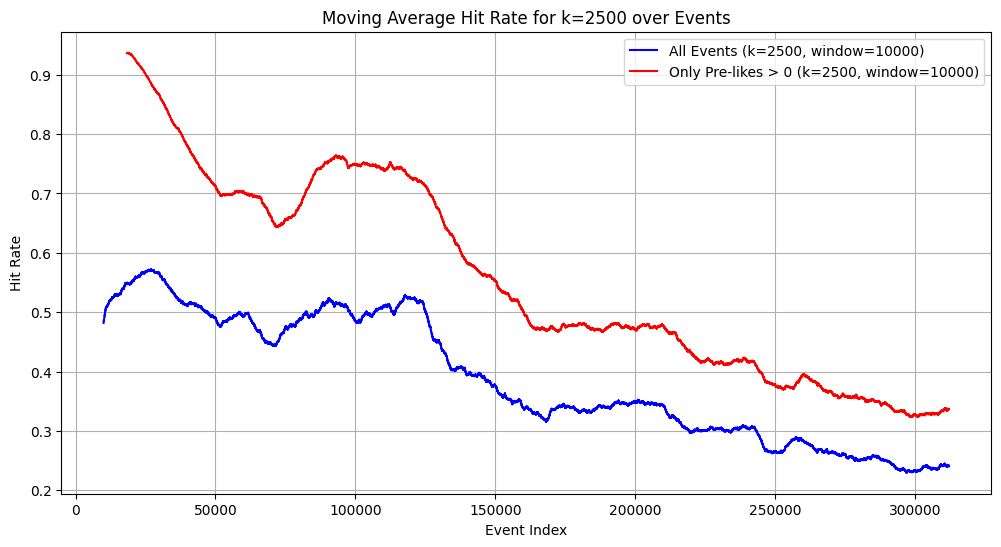

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Choose a target k value for plotting (e.g., k=100)
target_k = 2500

# Convert recommendation_results to a DataFrame
results_df = pd.DataFrame(recommendation_results)

# -----------------------------------------
# Plot Moving Average Hit Rate Over Event Index
# -----------------------------------------
# We'll smooth the hit rate over a fixed window
window_size = 10000

# Calculate moving averages for all events and events with pre_likes > 0
results_df['hit'] = results_df[f"hit_{target_k}"]
results_df['moving_avg_hit'] = results_df['hit'].rolling(window=window_size).mean()

# Create a filtered DataFrame for pre_likes > 0
results_df_filtered = results_df[results_df['pre_like_count'] > 0].copy()
results_df_filtered['moving_avg_hit'] = results_df_filtered['hit'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['moving_avg_hit'], 
         label=f'All Events (k={target_k}, window={window_size})', 
         color='blue')
plt.plot(results_df_filtered.index, results_df_filtered['moving_avg_hit'],
         label=f'Only Pre-likes > 0 (k={target_k}, window={window_size})',
         color='red')
plt.xlabel('Event Index')
plt.ylabel('Hit Rate')
plt.title(f'Moving Average Hit Rate for k={target_k} over Events')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def calculate_mrr(recommendation_results):
    total_rr = 0
    total_count = 0
    
    for event in recommendation_results:
        gt_post_idx = event['ground_truth_post_idx']
        
        # Use the largest k we have available
        top_k = event[f'top_{max(k_list)}']
        
        # Find position of ground truth (add 1 since position is 0-based)
        try:
            position = (top_k == gt_post_idx).nonzero()[0].item() + 1
            reciprocal_rank = 1.0 / position
        except:
            # Ground truth not in top-k
            reciprocal_rank = 0
            
        total_rr += reciprocal_rank
        total_count += 1
    
    mrr = total_rr / total_count
    return mrr

# Calculate overall MRR
mrr = calculate_mrr(recommendation_results)
print(f"\nOverall MRR: {mrr:.4f}")

# Calculate MRR for posts with previous likes
mrr_with_likes = calculate_mrr([event for event in recommendation_results if event['pre_like_count'] > 0])
print(f"MRR (posts with previous likes): {mrr_with_likes:.4f}")

# Calculate MRR for later 80% of data
total_events = len(recommendation_results)
start_idx = int(0.2 * total_events)
later_events = list(itertools.islice(recommendation_results, start_idx, total_events))
mrr_later = calculate_mrr(later_events)
print(f"MRR (later 80%): {mrr_later:.4f}")


Overall MRR: 0.0028
MRR (posts with previous likes): 0.0041
MRR (later 80%): 0.0020


In [14]:
# Initialize the Bluesky client
client = Client()
client.login('c-weed.bsky.social', 'bfv3-pzy2-r2lh-aoyp')

def get_profile(did):
    """Fetch profile information from Bluesky API"""
    try:
        response = client.get_profile(did)
        profile = {
            'handle': response.handle,
            'display_name': response.display_name,
            'description': response.description,
            'followers': response.followers_count,
            'following': response.follows_count,
            'posts': response.posts_count,
            'avatar': response.avatar,
            'joined': response.created_at
        }
        return profile
    except Exception as e:
        return {'handle': did, 'error': str(e)}

def get_post_content(uri):
    """Fetch post content from Bluesky API"""
    try:
        parts = uri.split('/')
        did = parts[2]
        rkey = parts[-1]
        
        response = client.get_post(
            post_rkey=rkey,
            profile_identify=did
        )
        
        # Get author profile
        author_profile = get_profile(did)
        
        content = {
            'text': response.value.text,
            'created_at': response.value.created_at,
            'uri': response.uri,
            'is_reply': response.value.reply is not None,
            'reply_to': response.value.reply.parent.uri if response.value.reply else None,
            'author': author_profile
        }
        return content
    except Exception as e:
        return {'text': f"Error fetching post: {str(e)}"}

def uri_to_bsky_link(uri):
    parts = uri.split('/')
    if len(parts) >= 3:
        did = parts[2]
        tid = parts[-1]
        return f"https://bsky.app/profile/{did}/post/{tid}"
    return uri

# Ensure inverse mappings exist
inv_consumer_mapping = {idx: did for did, idx in consumer_to_idx.items()}
inv_post_mapping = {idx: uri for uri, idx in post_to_idx.items()}

n_samples = 1
sampled_events = random.sample(recommendation_results, n_samples)

for event in sampled_events:
    event_index = recommendation_results.index(event)
    print(f"\n=== Event {event_index} at {event['timestamp']} ===")
    
    # Get consumer info
    consumer_did = inv_consumer_mapping.get(event["consumer_idx"], "unknown")
    consumer_profile = get_profile(consumer_did)
    profile_url = f"https://bsky.app/profile/{consumer_did}"
    
    # Compact consumer info with clickable link
    consumer_info = [
        ["@" + consumer_profile.get('handle', 'unknown'), 
         consumer_profile.get('display_name', ''),
         f"👥 {consumer_profile.get('followers', '0')}",
         f"📝 {consumer_profile.get('posts', '0')}",
         f"({profile_url})"]
    ]
    print("\nConsumer:")
    print(tabulate(consumer_info, tablefmt="plain"))
    
    # Ground truth post - fetch content first
    gt_post_uri = inv_post_mapping.get(event["ground_truth_post_idx"], None)
    gt_post_content = get_post_content(gt_post_uri) if gt_post_uri else {'text': 'Unknown post'}
    gt_post_link = uri_to_bsky_link(gt_post_uri) if gt_post_uri else "unknown"
    
    print("\nLiked post:")
    gt_info = [[
        f"@{gt_post_content.get('author', {}).get('handle', 'unknown')}",
        f"[idx: {event['ground_truth_post_idx']}]",
        gt_post_content.get('text', 'No content')[:100],
        f"({gt_post_link})"
    ]]
    print(tabulate(gt_info, tablefmt="plain"))
    
    # Recommendations
    print("\nRecommendations:")
    top20_tensor = event.get("top_20")
    top20 = top20_tensor.tolist() if hasattr(top20_tensor, "tolist") else list(top20_tensor)
    
    recommendations_data = []
    for rank, post_idx in enumerate(top20, start=1):
        post_uri = inv_post_mapping.get(post_idx, None)
        post_content = get_post_content(post_uri) if post_uri else {'text': 'Unknown post'}
        post_link = uri_to_bsky_link(post_uri) if post_uri else "unknown"
        
        author = post_content.get('author', {})
        recommendations_data.append([
            f"{rank}.",
            f"@{author.get('handle', 'unknown')}",
            f"[idx: {post_idx}]",  # Added post index
            post_content.get('text', 'No content')[:80] + "..." if len(post_content.get('text', '')) > 80 else post_content.get('text', 'No content'),
            f"{post_link}"
        ])
    
    print(tabulate(
        recommendations_data,
        headers=["#", "Author", "Post Index", "Content", "Link"],
        tablefmt="plain"
    ))


=== Event 185121 at 2023-06-15 16:18:54.704000 ===

Consumer:
@elifitch.bsky.social  Eli  👥 206  📝 297  (https://bsky.app/profile/did:plc:tzcsxnzrznoum7mu6mpo566q)

Liked post:
@brandon.insertcredit.com  [idx: 35467]  Please enjoy the absolutely bizarre trailer for a canceled wiiware game called Discipline, which was  (https://bsky.app/profile/did:plc:qpbuxrel3f3njvjw5rakf532/post/3jy7pnvy2p42w)

Recommendations:
  #  Author                        Post Index    Content                                                                              Link
  1  @tttori.bsky.social           [idx: 93483]  It's miserable.                                                                      https://bsky.app/profile/did:plc:pbeujml4ofya3aptq74kmeck/post/3jy7o7t2blz2y
  2  @paarsec.bsky.social          [idx: 56275]  I like the idea of hellthread but I’m also very shy and feel weird when folks ge...  https://bsky.app/profile/did:plc:ksltegtrtfqfkwzwpccvj3vg/post/3jy6zio3a5w2u
  3  @alisonbuki.bsky